In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install python-Levenshtein
import Levenshtein

from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation, DBSCAN

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('data.csv')
data.shape

(104411, 5)

In [ ]:
data.issue_date = pd.to_datetime(data.issue_date, utc=False)

In [ ]:
data.issuer_eng = data.issuer_eng.str.upper()

In [ ]:
data.dept_code.astype('str').map(len).value_counts(normalize=True)

6    0.926741
5    0.073259
Name: dept_code, dtype: float64

count    104411.000000
mean         65.164082
std          14.729673
min           3.000000
25%          58.000000
50%          67.000000
75%          76.000000
max         133.000000
Name: issuer_eng, dtype: float64

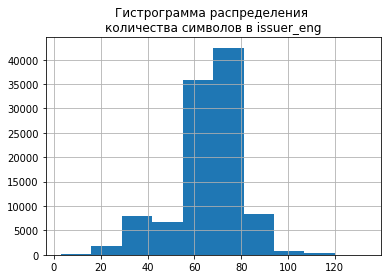

In [ ]:
plt.hist(data['issuer_eng'].map(len))
plt.grid()
plt.title('Гистрограмма распределения \nколичества символов в issuer_eng')
data['issuer_eng'].map(len).describe()

In [ ]:
symbols_dept_code = 6
symbols_issue_date = 8
symbols_issuer_avg = int(data['issuer_eng'].map(len).mean()) + 1
symbols_all = symbols_dept_code + symbols_issue_date + symbols_issuer_avg
temp =  symbols_all * 2
reduce_time = np.round(100000 * symbols_issuer_avg / temp, 2)
reduce_money = np.round(reduce_time * 0.05, 2)

In [ ]:
print('введение данных одного пользователя 30 секунд - в среднем ', symbols_all,
      'символов \nСредняя скорость набора символов:', temp, 'символов в минуту\n',
      'Зарплата оператора 0.05 евро в минуту')
print('\nОценка оптимизации: \nавтоподбор слова только по dept_code и issue_date \nкаждый год новые 100 тыс пользователей, без оптимизации оператор тратит',
     50000, 'минут в год на ввод данных новых клиентов. \nСтоимость данной работы ', 50000 * 0.05,
      'в год. \nЕсли учесть, что в среднем на заполнение issuer требуется', symbols_issuer_avg, 'символов',
      '\nАвтозаполнение может уменьшить время ввода данных на ', reduce_time, 'минут',
      '\nВ денежном эквиваленте произойдет оптимизация в среднем на', reduce_money, 'евро в год')

введение данных одного пользователя 30 секунд - в среднем  80 символов 
Средняя скорость набора символов: 160 символов в минуту
 Зарплата оператора 0.05 евро в минуту

Оценка оптимизации: 
автоподбор слова только по dept_code и issue_date 
каждый год новые 100 тыс пользователей, без оптимизации оператор тратит 50000 минут в год на ввод данных новых клиентов. 
Стоимость данной работы  2500.0 в год. 
Если учесть, что в среднем на заполнение issuer требуется 66 символов 
Автозаполнение может уменьшить время ввода данных на  41250.0 минут 
В денежном эквиваленте произойдет оптимизация в среднем на 2062.5 евро в год


# Пункт 2

In [ ]:
train_size = int(len(data) * 0.7) + 1

In [ ]:
needed_data = data.copy().drop(['issuer', 'values'], axis=1)

In [ ]:
train, test = train_test_split(needed_data, train_size = train_size, shuffle = True)
train.head()

,dept_code,issue_date,issuer_eng
46180,360004,2009-01-18,OTDELOM UFMS ROSSII PO VORONEZHSKOJ OBLASTI V ...
56926,380010,2015-07-07,OTDELOM UFMS ROSSII PO IRKUTSKOJ OBLASTI V GOR...
100288,860003,2016-01-07,OTDELOM UFMS ROSSII PO HANTY-MANSIJSKOMU AVTON...
93675,660009,2016-08-09,OUFMS ROSSII PO SVERDLOVSKOJ OBL. V CHKALOVSKO...
86702,640004,2015-05-15,OTDELOM UFMS ROSSII PO SARATOVSKOJ OBLASTI V L...


In [ ]:
def filter_by_depth(base, dept, date):
    lay_1 = base[base.dept_code == dept].copy()
    closest_date_idx =  closest_time(lay_1.issue_date, date)
    return lay_1.issuer_eng[closest_date_idx]

def closest_time(date_row, date):
    df_time = pd.DataFrame({'date' : date_row, 'differ' : abs(data.issue_date - pd.to_datetime(date, utc=False))},
                          index= date_row.index)    
    return df_time.differ.idxmin()

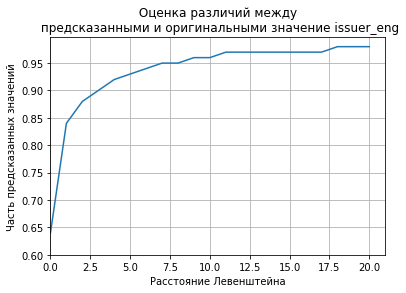

In [ ]:
# result_1 = pd.Series(list(test[['dept_code', 'issue_date']].values)).apply(lambda x: filter_by_depth(train, x[0], x[1]))

check_1 = pd.Series(list(pd.DataFrame({'result_0' : result_1, 'target': test.issuer_eng.to_list()}).values))
distance_1 = check_1.apply(lambda x: Levenshtein.distance(x[0], x[1]))

def plot_Levenstein(distance, ylim=0.6):
  x = np.linspace(0, 20, 21)
  y = [np.round((distance <= i).sum() / len(distance), 2) for i in x]
  plt.plot(x, y)
  plt.ylim(ylim)
  plt.xlim(0)
  plt.grid()
  plt.xlabel('Расстояние Левенштейна')
  plt.ylabel('Часть предсказанных значений')
  plt.title(' Оценка различий между \n предсказанными и оригинальными значение issuer_eng')
  plt.show()

plot_Levenstein(distance_1)

# Пункт 3

In [ ]:
dept_code = train.dept_code.unique()
train['examplar'] = train.loc[:, 'issuer_eng']

In [ ]:
exeption_dept_code = []
for dept in dept_code:
  needed_idx = train[train.dept_code == dept].index #индексы тех строчек, где dept_code = dept
  current_train = train.loc[needed_idx, :].copy() #рассматриваем ту часть train dateframe, где dept_code = dept
  unique_issuer = current_train.issuer_eng.unique() # уникальные значения issuer_eng, которые соотвествуют данному dept
  IsEng_to_index_in_uniqueIsEng = { issuer: index for index, issuer in enumerate(unique_issuer)} # словарь, в котором каждому уникальному issuer_eng соответствует его индекс в листе уникальных значений
  current_examplar = current_train.loc[:, 'examplar'].copy()#рассматриваем ту часть examplar в train dateframe, 
  #где dept_code = dept, сейчас в этом столбце просто повторяются значения issuer_eng
  unique_issuer = current_train.issuer_eng.unique() # уникальные значения issuer_eng, которые соотвествуют данному dept
  current_examplar = current_examplar.map(IsEng_to_index_in_uniqueIsEng) # вместо значений issuer_eng мы пишем его индекс в списке уникальных значений unique_issuer  

  # симметричная матрица расстояний Левенштейна между уникальными issuer_eng
  lev_matrix = pd.DataFrame(index=unique_issuer, columns=unique_issuer) 
  k = 0
  for i in unique_issuer:
      for j in unique_issuer[k: ]:
          lev_matrix.loc[i, j] = Levenshtein.distance(i, j)
          lev_matrix.loc[j, i] = lev_matrix.loc[i, j]
  model = AffinityPropagation().fit(lev_matrix) # кластерезуем уникальные значения issuer_eng, методу AffinityPropagation
  # на обучение подается матрица расстояний

  # Алгоритм делит уникальные значения на несколько классов, которые нумеруют от 0 до n. 
  #Теперь мы должны сопоставим каждому элементу кластер и в examlar написать уникальное слова,
  # которое является центром его класса
  issuier_eng_centeres = { i: unique_issuer[i] for i in model.cluster_centers_indices_} # Каждому классу [0,..,n] сопоставляет
  #уникального значение из unique_issuer, которое стало центром данного класса
  center_indexes = {i: center_index for i, center_index in enumerate(model.cluster_centers_indices_)}  # Каждому классу [0,..,n] сопоставляет
  # индекс уникального значение из unique_issuer, которое стало центром данного класса
  clusrering_index = pd.Series(model.labels_).map(center_indexes) # всем уникальным значениям issuer_eng сопоставляет
  # индекс issuer_eng в листе unique_issuer, который является центром их классов 
  
  current_examplar = current_examplar.map({i: center_idx for i, center_idx in enumerate(clusrering_index)}) # Вместо индекса значения issuer_eng 
  # в листе unique_issuer в exampar ставится индекс центра класса, к которому отнесено данное issuer_eng
  current_examplar = current_examplar.map(issuier_eng_centeres)  # Вместо индекса центра, к которому отнесенно данное issuer eng,
  #ставится issuer_eng центра  

  if current_examplar.isnull().sum() != 0 : # Фиксация тех dept_code, для которых не получилось кластеризовать unique issuer_eng
    exeption_dept_code.append(dept)         # Если кластеризация прошла успешно, то в столбец examplar записывает issuer_eng центра, соответсвуещего класса
  else:
    train.examplar[needed_idx] = current_examplar
print(exeption_dept_code)


[632033, 340011, 282002, 280002, 410001]


In [ ]:
# train_new = train.query('dept_code != 632033 & dept_code != 340011 & dept_code != 282002 & dept_code != 280002 & dept_code != 410001')
# test_new = test.query('dept_code != 632033 & dept_code != 340011 & dept_code != 282002 & dept_code != 280002 & dept_code != 410001')

In [ ]:
def filter_by_depth_new(base, dept, date):
    lay_1 = base[base.dept_code == dept].copy()
    closest_date_idx =  closest_time(lay_1.issue_date, date)
    return lay_1.examplar[closest_date_idx]

result_2 = pd.Series(list(test[['dept_code', 'issue_date']].values)).apply(lambda x: filter_by_depth_new(train, x[0], x[1]))


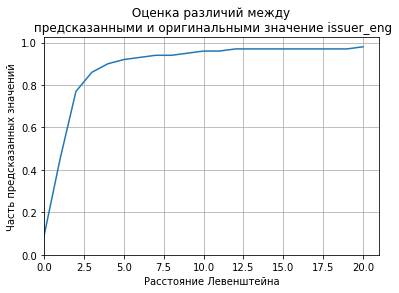

In [ ]:
check_2 = pd.Series(list(pd.DataFrame({'result_2' : result_2, 'target': test.issuer_eng.to_list()}).values))
distance_2 = check_2.apply(lambda x: Levenshtein.distance(x[0], x[1]))
plot_Levenstein(distance_2, 0)

# x = np.linspace(0, 20, 21)
# y = [np.round((distance_2 <= i).sum() / len(distance_2), 2) for i in x]
# plt.plot(x, y)
# plt.ylim(0)
# plt.xlim(0)
# plt.grid()